# Introduction

## Objective <br>
Using the titanic machine learning dataset from kaggle (https://www.kaggle.com/competitions/titanic/overview), we will predict the survival of passengers based on specific variables. <br>
For learning purposes, this project is done in order to gain familiarity with machine learning basics and overall the workflow, from data exploration, data preprocessing, to model building and evaluation. <br>

## Data <br>

The data is split into two separate files: <br>
    - train.csv <br>
    - test.csv <br>

The train dataset is used for data exploration and feature engineering. The train and test dataset contain features such as passenger class, gender, fare and age. Only the train dataset contains the ground truth (survival of each passenger), while the test dataset does not. Additional features can be created using existing ones. The model(s) are built and trained using the train dataset and evaluated based key metrics pertaining to classification models. <br>

The test dataset is used to generate predictions from the model built using the train dataset. The test dataset predictions are then saved into a csv file to be submitted to Kaggle to get an accuracy score and a leaderboard placement


## Contents <br>
1. Import data <br>
2. Data exploration <br>
3. Data pre-processing and feature engineering <br>
4. Model training <br>
5. Model evaluation and comparison <br>
6. Test predictions 

## 1. Import data

In [1]:
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()    


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

titanic_train = load_titanic_data("train.csv")
titanic_test = load_titanic_data("test.csv")

titanic_train_labels = titanic_train["Survived"].values
titanic_train_labels.mean()

0.3838383838383838

Approximately 38% of the passengers in the training set survived

## 2. Exploration of training data

In [3]:
titanic_train_explore = titanic_train.copy()

In [4]:
titanic_train_explore.shape

(891, 12)

In [5]:
titanic_train_explore.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
titanic_train_explore.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

"Age", "Cabin" and "Embarked" variable contain null values

In [7]:
print("% of null values")
print("Embarked: {}%".format(round(((len(titanic_train_explore[titanic_train_explore["Embarked"].isna() == True]))/(len(titanic_train_explore)) * 100)),3))
print("Cabin: {}%".format(round(((len(titanic_train_explore[titanic_train_explore["Cabin"].isna() == True]))/(len(titanic_train_explore)) * 100)),2))
print("Age: {}%".format(round(((len(titanic_train_explore[titanic_train_explore["Age"].isna() == True]))/(len(titanic_train_explore)) * 100)),2))

% of null values
Embarked: 0%
Cabin: 77%
Age: 20%


"Cabin" has 77% null values, while "Age" and "Embarked" have 22% and 0% null values respectively <br>
"Age" is a numerical variable and the null values will have to be imputed via some strategy <br>
"Embarked" and "Cabin" are categorical variables, however, "Embarked" will likely be imputed via some strategy due to it only having 2 null values

### 2a) Embarked

In [8]:
titanic_train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

<AxesSubplot:xlabel='Embarked'>

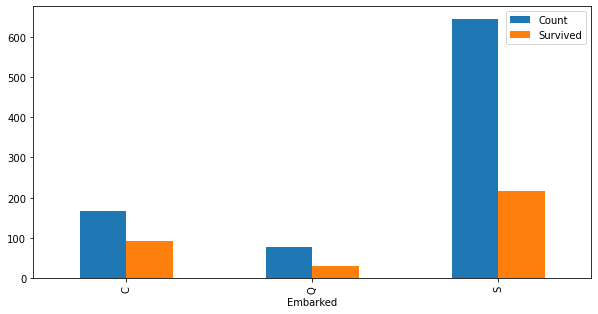

In [9]:
embarked_count = pd.DataFrame(titanic_train_explore.groupby(["Embarked"]).count()["Survived"]).sort_index()
embarked_count = embarked_count.rename(columns = {"Survived": "Count"})

embarked_survived = pd.DataFrame(titanic_train_explore.groupby(["Embarked"]).sum()["Survived"]).sort_index()
embarked = pd.merge(embarked_count, embarked_survived, on = "Embarked")
embarked.plot(kind = "bar", figsize = (10,5))


Majority of the passengers embarked from Southampton

### 2b) Sex

In [10]:
titanic_train_explore["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

<AxesSubplot:xlabel='Sex'>

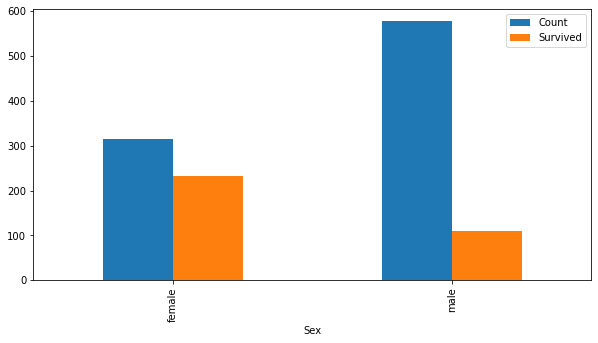

In [11]:
gender_count = pd.DataFrame(titanic_train_explore.groupby(["Sex"]).count()["Survived"]).sort_index()
gender_count = gender_count.rename(columns = {"Survived": "Count"})

gender_survived = pd.DataFrame(titanic_train_explore.groupby(["Sex"]).sum()["Survived"]).sort_index()
gender = pd.merge(gender_count, gender_survived, on = "Sex")
gender.plot(kind = "bar", figsize = (10,5))

Although there are more male passengers than female passengers, more female passengers survived than male passengers

### 2c) Pclass

In [12]:
titanic_train_explore["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

<AxesSubplot:xlabel='Pclass'>

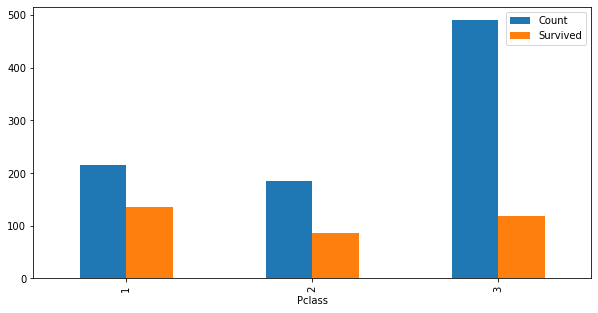

In [13]:
pclass_count = pd.DataFrame(titanic_train_explore.groupby(["Pclass"]).count()["Survived"]).sort_index()
pclass_count = pclass_count.rename(columns = {"Survived": "Count"})

pclass_survived = pd.DataFrame(titanic_train_explore.groupby(["Pclass"]).sum()["Survived"]).sort_index()
pclass = pd.merge(pclass_count, pclass_survived, on = "Pclass")
pclass.plot(kind = "bar", figsize = (10,5))

Although 1st class passengers did not form the majority of passengers, they formed the majority of survivors <br>
3rd class passengers formed the majority of passengers, yet they did not form the majority of survivors. Small percentage of 3rd class passengers survived

### 2d) Age

In [14]:
titanic_train_explore["Age"].describe()

count    714.000000
mean      29.699113
std       14.526507
min        0.416700
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

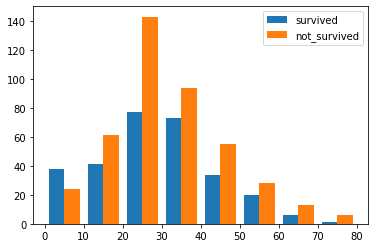

In [15]:
age_survived = titanic_train_explore[titanic_train_explore["Survived"] == 1]["Age"].values
age_not_survived = titanic_train_explore[titanic_train_explore["Survived"] == 0]["Age"].values
age_bins = sorted(list(set(((titanic_train_explore.dropna(subset = ["Age"])["Age"]//10) * 10).astype(int))))

plt.hist([age_survived, age_not_survived], age_bins, label=['survived', 'not_survived'])
plt.legend(loc='upper right')
plt.show()

Most of the passengers in the 0 to 10 years old age group survived. The age group with the highest number of non survivors is 20 to 30 years old

### 2e) Fare

In [16]:
titanic_train_explore["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

<AxesSubplot:title={'center':'Fare'}, xlabel='[Survived]'>

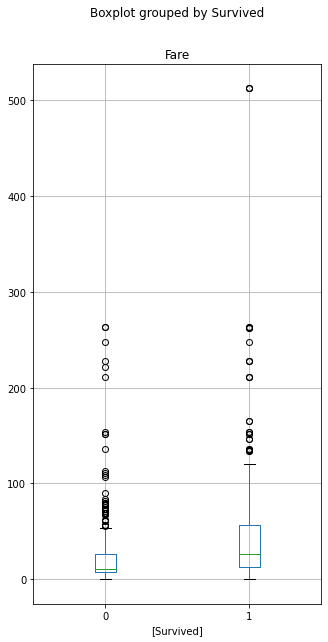

In [17]:
titanic_train_explore[["Fare", "Survived"]].boxplot(by = ["Survived"], figsize = (5,10))

Surviving passengers have a higher median fare compared to that of non-surviving passengers. The fare spread of surviving passengers is much wider than that of non-surviving passengers

### 2f) Sibsp and Parch

In [18]:
titanic_train_explore["SibSp"].describe()

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

In [19]:
titanic_train_explore["Parch"].describe()

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

In [20]:
titanic_train_explore["travel_alone"] = np.where(titanic_train_explore["SibSp"]+titanic_train_explore["Parch"] > 0, 1, 0)

<AxesSubplot:xlabel='travel_alone'>

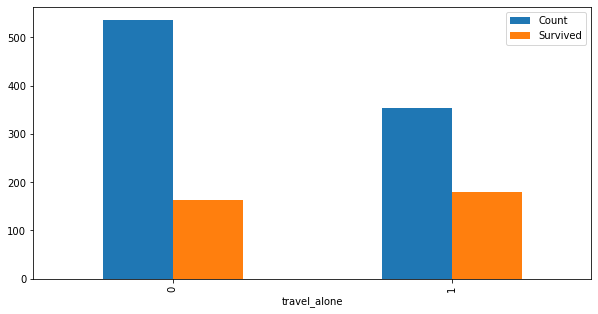

In [21]:
travel_alone_count = pd.DataFrame(titanic_train_explore.groupby(["travel_alone"]).count()["Survived"]).sort_index()
travel_alone_count = travel_alone_count.rename(columns = {"Survived": "Count"})

travel_alone_survived = pd.DataFrame(titanic_train_explore.groupby(["travel_alone"]).sum()["Survived"]).sort_index()
travel_alone = pd.merge(travel_alone_count, travel_alone_survived, on = "travel_alone")
travel_alone.plot(kind = "bar", figsize = (10,5))

There are more passengers that did not travel alone, however passengers who travelled alone formed the majority of survivors

The relevant variables that will be used to train the model are split into numerical variables, categorical variables and binary variables <br> <br>
Each set of variables will go through a separate data pre-processing pipeline, and then unioned together to consolidate the prepared training data

In [22]:
num_variables = ["Pclass", "Age", "Fare"]
cat_variables = ["Sex", "Embarked"]
bin_variables = ["travel_alone"]

## 3. Data pre-processing and feature engineering

A few helper classes are created to form the pipeline for each set of variables: <br> <br>
    1. NewVariablesCreator: Create new variables for feature engineering <br> <br>
    2. VariableSelector: Selects relevant variables from the training data<br> <br>
    3. NumericalValueImputer: Uses a strategy (mean or median) and a list of variable(s) to aggregate, to impute null values in numerical variables (eg Impute median age for each gender for null age values) <br> <br>
    4. CategoricalValueImputer: Uses a mode strategy to impute null values in categorical variables

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin 

class NewVariablesCreator(BaseEstimator, TransformerMixin):
    def __init__(self, age_buckets = False, travel_alone = False):
        self.age_buckets = age_buckets
        self.travel_alone = travel_alone
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        if self.age_buckets:
            bucket_size = 15
            X["Age_bucket"] = (X["Age"]//bucket_size) * bucket_size

        if self.travel_alone:
            X["travel_alone"] = np.where(X["SibSp"] + X["Parch"] > 0, 1, 0)

        return X


In [24]:
class VariableSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_keep):
        self.columns_to_keep = columns_to_keep
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X =  X[self.columns_to_keep]
        
        return X

In [25]:
class NumericalValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, impute_column, agg_columns, strategy):
        self.impute_column = impute_column
        self.agg_columns = agg_columns
        self.strategy = strategy
        
    def fit(self, X, y = None):
        return self

    def transform(self, X):
        if self.strategy == "median":
            groupby_df = pd.DataFrame(X.groupby(self.agg_columns).median()[self.impute_column])
        elif self.strategy == "mean":
            groupby_df = pd.DataFrame(X.groupby(self.agg_columns).mean()[self.impute_column])
                
        X[self.impute_column] =  X[self.impute_column].fillna(X[self.agg_columns].apply(lambda x: groupby_df.loc[tuple(x[col] for col in self.agg_columns)].values[0], axis = 1))
        
        return X

In [26]:
class CategoricalValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, impute_column):
        self.impute_column = impute_column
    
    def fit(self, X, y = None):
        return self
        
    def transform(self, X):
        X[self.impute_column] = X[self.impute_column].fillna(X[self.impute_column].mode()[0])
        
        return X

<b>Pipeline for numerical variables:<b><br>
1. Impute null values in "Age" using the median value of each "Pclass" <br> <br>
2. Impute null values in "Fare" using the median value of each "Pclass" <br> <br>
3. Select the relevant numerical variables <br> <br>
4. Scale numerical variables using sklearn StandardScaler

In [27]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_pipeline = Pipeline([("median_age_by_pclass_imputer", NumericalValueImputer("Age", ["Pclass"], "median")),
                         ("median_fare_by_pclass_imputer", NumericalValueImputer("Fare", ["Pclass"], "median")),
                         ("attr_selector", VariableSelector(num_variables)),
                         ("standard_scaler", StandardScaler())])

<b>Pipeline for categorical variables:<b><br>
1. Impute null values in "Embarked" using the mode value <br> <br>
2. Select the relevant categorical variables <br> <br>
3. One-hot encode catgorical variables using sklearn OneHotEncoder

In [28]:
cat_pipeline = Pipeline([("embarked_mode_value_imputer", CategoricalValueImputer("Embarked")),
                         ("attr_selector", VariableSelector(cat_variables)),
                         ("one_hot_encoder", OneHotEncoder(sparse=False))])

<b>Pipeline for binary variables:<b><br>
1. Create new variable "travel_alone" <br> <br>
2. Select the relevant binary variables <br> <br>


In [29]:
bin_pipeline = Pipeline([("create_travel_alone", NewVariablesCreator(travel_alone = True)),
                         ("attr_selector", VariableSelector(bin_variables))])

Full pipeline unions numerical variables, categorical variables, and binary variables after passing through their respective pipelines

In [30]:
full_pipeline = FeatureUnion([("num_pipeline", num_pipeline),
                              ("cat_pipeline", cat_pipeline),
                              ("bin_pipeline", bin_pipeline)])

titanic_train_final = full_pipeline.fit_transform(titanic_train)

In [31]:
pd.DataFrame(titanic_train_final)

,0,1,2,3,4,5,6,7,8
0,0.827377,-0.533833,-0.502445,0.0,1.0,0.0,0.0,1.0,1.0
1,-1.566107,0.674890,0.786845,1.0,0.0,1.0,0.0,0.0,1.0
2,0.827377,-0.231652,-0.488854,1.0,0.0,0.0,0.0,1.0,0.0
3,-1.566107,0.448255,0.420730,1.0,0.0,0.0,0.0,1.0,1.0
4,0.827377,0.448255,-0.486337,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
886,-0.369365,-0.156107,-0.386671,0.0,1.0,0.0,0.0,1.0,0.0
887,-1.566107,-0.760469,-0.044381,1.0,0.0,0.0,0.0,1.0,0.0
888,0.827377,-0.382743,-0.176263,1.0,0.0,0.0,0.0,1.0,1.0
889,-1.566107,-0.231652,-0.044381,0.0,1.0,1.0,0.0,0.0,0.0


## 4. Model training

### 4a) Stochastic Gradient Descent Classifier

In [32]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(titanic_train_final, titanic_train_labels)

SGDClassifier(random_state=42)

In [33]:
from sklearn.model_selection import cross_val_score, cross_val_predict
print("Mean accuracy = {}".format(cross_val_score(sgd_clf, titanic_train_final, titanic_train_labels, cv = 8, scoring = "accuracy").mean()))

Mean accuracy = 0.7621159105534105


Training a stochastic gradient descent classifier, with 8-fold cross validation, the average accuracy is about 78%. The model was able to correctly predict is a passenger survived or not for about 78% of the training data

In [34]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, accuracy_score
y_pred = cross_val_predict(sgd_clf, titanic_train_final, titanic_train_labels, cv = 8)
y_pred_scores = cross_val_predict(sgd_clf, titanic_train_final, titanic_train_labels, cv = 8, method = "decision_function")

print("SGD Classifier, 8 folds")
print("Precision = {}".format(precision_score(titanic_train_labels, y_pred)))
print("Recall = {}".format(recall_score(titanic_train_labels, y_pred)))
print("Accuracy = {}".format(accuracy_score(titanic_train_labels, y_pred)))

SGD Classifier, 8 folds
Precision = 0.6857142857142857
Recall = 0.7017543859649122
Accuracy = 0.7620650953984287


True Positive (TP) - Actual: Survived, Predicted: Survived <br>
True Negative (TN) - Actual: Does not survive, Predicted: Does not survive <br>
False Positive (FP) - Actual: Does not survive, Predicted: Survived <br>
False Negative (FN) - Actual: Survived, Predicted: Does not survive <br> <br>

Precision = TP/(TP+FP) <br>
The precision score measures the ratio of correctly predicted positives to all predicted positives <br> <br>

Recall = TP/(TP+FN) <br>
The precision score measures the ratio of correctly predicted positives to all actual positives <br> <br>

Accuracy = (TP+TN)/(TP+TN+FP+FN) <br> 
The accuracy score measures the ratio of correctly predicted outcomes to the whole dataset <br> <br>

The SGD classifer has a precision score of 0.69, indicating that it correctly predicts surviving passengers 69% of the time <br>
The SGD classifier has a recall score of 0.70, indicating that it correctly predicts about 70% of the training data surviving passengers <br>

Intrestingly to note, in this context of training a classifer to predict surviving passengers, a higher precision score/lower recall score is preferred. This would mean preferring a classifier that places more emphasis on reducing false positives and correctly predicting surviving passengers

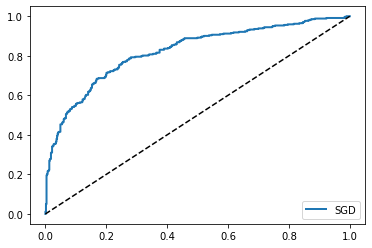

SGD Classifier, 8 folds
AUC = 0.8218344890763642


In [35]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], "k--")

from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds  = roc_curve(titanic_train_labels, y_pred_scores)
plot_roc_curve(fpr, tpr, label = "SGD")
plt.legend(loc = "lower right")
plt.show()
print("SGD Classifier, 8 folds")
print("AUC = {}".format(roc_auc_score(titanic_train_labels, y_pred_scores)))

Training a stochastic gradient descent classifier, with 8-fold cross validation, the area under the recieved operating curve is 0.82, which is quite decent as it is quite far away from the diagonal dotted line which represents a purely random classifier

### 4b) Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

log_reg_clf = LogisticRegression(random_state = 42)
log_reg_clf.fit(titanic_train_final, titanic_train_labels)

LogisticRegression(random_state=42)

In [37]:
log_reg_pred = cross_val_predict(log_reg_clf, titanic_train_final, titanic_train_labels, cv = 8)
log_reg_pred_scores = cross_val_predict(log_reg_clf, titanic_train_final, titanic_train_labels, cv = 8, method = "decision_function")

print("Logistic Regression Classifier, 8 folds")
print("Precision = {}".format(precision_score(titanic_train_labels, log_reg_pred)))
print("Recall = {}".format(recall_score(titanic_train_labels, log_reg_pred)))
print("Accuracy = {}".format(accuracy_score(titanic_train_labels, log_reg_pred)))

Logistic Regression Classifier, 8 folds
Precision = 0.7422360248447205
Recall = 0.6988304093567251
Accuracy = 0.7912457912457912


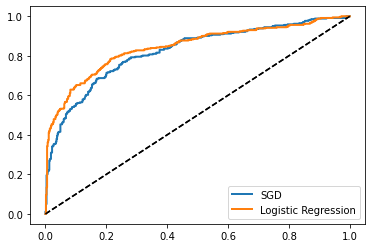

Logistic Regression Classifier, 8 folds
AUC = 0.8445179433100054


In [38]:
fpr_log_reg, tpr_log_reg, thresholds_log_reg  = roc_curve(titanic_train_labels, log_reg_pred_scores)
plot_roc_curve(fpr, tpr, label = "SGD")
plot_roc_curve(fpr_log_reg, tpr_log_reg, label = "Logistic Regression")
plt.legend(loc = "lower right")
plt.show()
print("Logistic Regression Classifier, 8 folds")
print("AUC = {}".format(roc_auc_score(titanic_train_labels, log_reg_pred_scores)))

### 4b) Random Forest Classifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
forest_clf.fit(titanic_train_final, titanic_train_labels)


RandomForestClassifier(random_state=42)

In [40]:
forest_clf_probs = cross_val_predict(forest_clf, titanic_train_final, titanic_train_labels, cv = 8, method = "predict_proba")
y_pred_scores_forest = forest_clf_probs[:,1]
y_pred_forest = (y_pred_scores_forest >= 0.5)

print("Random Forest Classifier, 8 folds")
print("Precision = {}".format(precision_score(titanic_train_labels, y_pred_forest)))
print("Recall = {}".format(recall_score(titanic_train_labels, y_pred_forest)))
print("Accuracy = {}".format(accuracy_score(titanic_train_labels, y_pred_forest)))

Random Forest Classifier, 8 folds
Precision = 0.7659574468085106
Recall = 0.7368421052631579
Accuracy = 0.8125701459034792


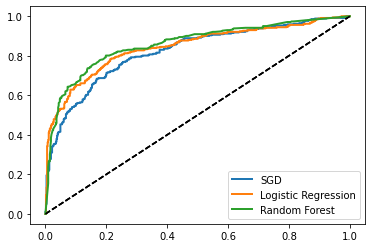

Random Forest Classifier, 8 folds
AUC = 0.8592763024744619


In [41]:
fpr_forest, tpr_forest, thresholds_forest  = roc_curve(titanic_train_labels, y_pred_scores_forest)
plot_roc_curve(fpr, tpr, label = "SGD")
plot_roc_curve(fpr_log_reg, tpr_log_reg, label = "Logistic Regression")
plot_roc_curve(fpr_forest, tpr_forest, label = "Random Forest")
plt.legend(loc = "lower right")
plt.show()
print("Random Forest Classifier, 8 folds")
print("AUC = {}".format(roc_auc_score(titanic_train_labels, y_pred_scores_forest)))

### 4c) Support Vector Machine Classifier

In [42]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(titanic_train_final, titanic_train_labels)

SVC(gamma='auto')

In [43]:
svm_clf_pred = cross_val_predict(svm_clf, titanic_train_final, titanic_train_labels, cv = 8)
svm_clf_scores = cross_val_predict(svm_clf, titanic_train_final, titanic_train_labels, cv = 8, method = "decision_function")

print("Support Vector Classifier, 8 folds")
print("Precision = {}".format(precision_score(titanic_train_labels, svm_clf_pred)))
print("Recall = {}".format(recall_score(titanic_train_labels, svm_clf_pred)))
print("Accuracy = {}".format(accuracy_score(titanic_train_labels, svm_clf_pred)))

Support Vector Classifier, 8 folds
Precision = 0.8494208494208494
Recall = 0.6432748538011696
Accuracy = 0.819304152637486


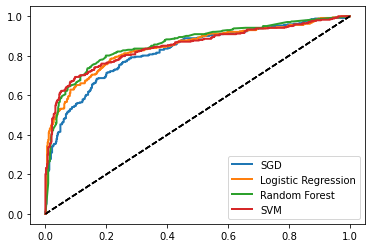

Support Vector Classifier, 8 folds
AUC = 0.8481928865880548


In [44]:
fpr_svm, tpr_svm, thresholds_svm  = roc_curve(titanic_train_labels, svm_clf_scores)
plot_roc_curve(fpr, tpr, label = "SGD")
plot_roc_curve(fpr_log_reg, tpr_log_reg, label = "Logistic Regression")
plot_roc_curve(fpr_forest, tpr_forest, label = "Random Forest")
plot_roc_curve(fpr_svm, tpr_svm, label = "SVM")
plt.legend(loc = "lower right")
plt.show()
print("Support Vector Classifier, 8 folds")
print("AUC = {}".format(roc_auc_score(titanic_train_labels, svm_clf_scores)))

## 5) Model evaluation and comparison

In [45]:
sgd_clf_precision = precision_score(titanic_train_labels, y_pred)
sgd_clf_recall = recall_score(titanic_train_labels, y_pred)
sgd_clf_accuracy = accuracy_score(titanic_train_labels, y_pred)
sgd_clf_AUC = roc_auc_score(titanic_train_labels, y_pred_scores)

log_reg_clf_precision = precision_score(titanic_train_labels, log_reg_pred)
log_reg_clf_recall = recall_score(titanic_train_labels, log_reg_pred)
log_reg_clf_accuracy = accuracy_score(titanic_train_labels, log_reg_pred)
log_reg_clf_AUC = roc_auc_score(titanic_train_labels, log_reg_pred_scores)

forest_clf_precision = precision_score(titanic_train_labels, y_pred_forest)
forest_clf_recall = recall_score(titanic_train_labels, y_pred_forest)
forest_clf_accuracy = accuracy_score(titanic_train_labels, y_pred_forest)
forest_clf_AUC = roc_auc_score(titanic_train_labels, y_pred_scores_forest)

svm_clf_precision = precision_score(titanic_train_labels, svm_clf_pred)
svm_clf_recall = recall_score(titanic_train_labels, svm_clf_pred)
svm_clf_accuracy = accuracy_score(titanic_train_labels, svm_clf_pred)
svm_clf_AUC = roc_auc_score(titanic_train_labels, svm_clf_scores)


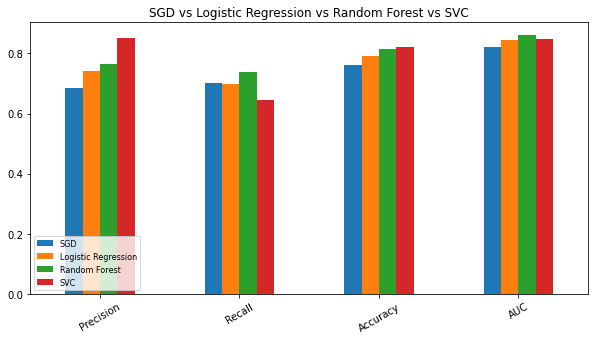

In [47]:
sgd_clf_metrics = {"Precision" : sgd_clf_precision, "Recall" : sgd_clf_recall, "Accuracy" : sgd_clf_accuracy, "AUC" : sgd_clf_AUC}
log_reg_clf_metrics = {"Precision" : log_reg_clf_precision, "Recall" : log_reg_clf_recall, "Accuracy" : log_reg_clf_accuracy, "AUC" : log_reg_clf_AUC}
forest_clf_metrics = {"Precision" : forest_clf_precision, "Recall" : forest_clf_recall, "Accuracy" : forest_clf_accuracy, "AUC" : forest_clf_AUC}
svm_clf_metrics = {"Precision" : svm_clf_precision, "Recall" : svm_clf_recall, "Accuracy" : svm_clf_accuracy, "AUC" : svm_clf_AUC}

clf_metrics = {}
clf_metrics["SGD"] = sgd_clf_metrics
clf_metrics["Logistic Regression"] = log_reg_clf_metrics
clf_metrics["Random Forest"] = forest_clf_metrics
clf_metrics["SVC"] = svm_clf_metrics

clf_metrics_df = pd.DataFrame(clf_metrics)

clf_metrics_df.plot(kind = "bar", figsize = (10,5))
plt.title("SGD vs Logistic Regression vs Random Forest vs SVC")
plt.legend(["SGD", "Logistic Regression", "Random Forest", "SVC"], loc='lower left',  prop={'size': 8})
plt.xticks(rotation=30, horizontalalignment="center")
plt.show()

The AUC scores for all the classifiers are quite close at just above 0.80. <br> 
The SVM classifier has the highest precision and accuracy. The classifier seems to be the best at correctly predicting surviving passengers most of the time, and also the best at  predicting actual outcomes. <br>
Also to note most classifiers have a higher precision score than recall score with varying differences. This would mean these classifiers have a greater emphasis on reducing false positives and correctly predicting surviving passengers.

In [48]:
def plot_precision_recall_vs_threshold(classifier, precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision", c = "g")
    plt.plot(thresholds, recalls[:-1], "b--", label = "Recall", c = "r")
    plt.legend(["Precision","Recall"], loc='lower left',  prop={'size': 8})
    plt.xlabel("Thresholds")
    plt.ylabel("Score")
    plt.title("{} Precision/Recall Scores vs Thresholds".format(classifier))

C:\Users\angus\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  
C:\Users\angus\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  This is separate from the ipykernel package so we can avoid doing imports until


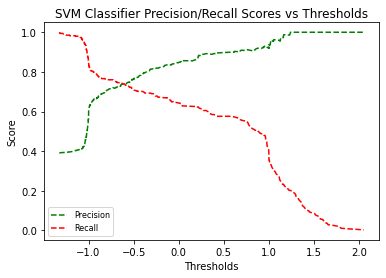

In [49]:
precisions, recalls, thresholds = precision_recall_curve(titanic_train_labels, svm_clf_scores)
plot_precision_recall_vs_threshold("SVM Classifier", precisions, recalls, thresholds)
plt.show()

Plotting the SVM Classifier's precision/recall scores for different thresholds, we can see that the precision score is greater than the recall score at the default threshold of 0 <b>

As the threshold increases, the precision score generall increases while the recall score generally decreases

## 6) Test predictions

In [50]:
titanic_test_passenger_ids = titanic_test["PassengerId"]
titanic_test_final = full_pipeline.fit_transform(titanic_test)

In [52]:
titanic_test_pred = pd.DataFrame()
titanic_test_pred["PassengerId"] = titanic_test_passenger_ids
titanic_test_pred["Survived"] = svm_clf.predict(titanic_test_final)

In [53]:
titanic_test_pred["Survived"].value_counts()

0    304
1    114
Name: Survived, dtype: int64

Running the raw test dataset through the pipeline and using the SVM classifier to predict the survival of the passengers in the test dataset, approximately 25% of the passengers are predicted to survive

In [54]:
titanic_test_pred.to_csv("titanic_kaggle_submission.csv", index = False)

The kaggle score obtained was 0.78468! It is quite close to the accuracy score of the training data. The trained model is decent in predicting the survival of new passengers, however there is definitely room for improvement

## Future steps <br>
1. Hyperparameter tuning (eg Grid Search, Randomized Search) to improve model performance
2. More feature engineering (eg specific names of passengers, age buckets, fare buckets)